# Fit Gompertz function to life table data

For details of the method to derive the log-likelihood, please see Adam Lenart, MPIDR Working Paper WP 2012-008, "The Gompertz distribution and Maximum Likelihood Estimation of its parametersa revision", February 2012

Assume that the number of deaths between age x to x + 1 follows a Poisson distribution. 
Poisson likelihood is:

$$ l(D_{t}) = \prod_t \frac{\lambda^{D_{t}}e^{-\lambda}}{D_{t}!} $$

Taking log of the likelihood:

$$ ll(D_{t}) = \sum _t D_{t} * ln(\lambda) - \lambda$$

The rate parameter ($\lambda$) in the Poisson distribution is replaced by the Gompertz hazard:

$$ h(t) = e^{\lambda + \gamma * t} $$

Poisson likelihood assumes that each observation of the number of deaths per time period $(D_{t})$ comes from the same number of person-years of exposure to risk during the same period $(E_{t})$, but in the lifetables, the number of person-years lived at each year is different. That is why we weight the rate parameter by the number of person-years at risk of death at that age in the likelihood function.

$$ ll(D_{t}) = \sum _t D_{t} * ln(\lambda) - E_{t}\lambda$$

In [1]:
#Integer division will return float value
from __future__ import division
import pandas as pd
%matplotlib inline
#Import GenericLikelihoodModel
from statsmodels.base.model import GenericLikelihoodModel
#Import matplotlib.pyplot for plotting results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Import numpy
import numpy as np
#Suppress scientific notation for numpy
np.set_printoptions(suppress=True)
#To set the working directory
import os as osvariable
osvariable.chdir("C:/Users/Mustafa/Desktop/Github/Survival_Analysis/Survival_Analysis")
#To read in csv file
from pandas import read_csv

In [2]:
#The lifetables are obtained from CDC
#http://www.cdc.gov/nchs/data/nvsr/nvsr64/nvsr64_11.pdf, Table 2 for Males and Table 3 for Females
lifetables_US = read_csv('lifetables_US.csv')
print(lifetables_US.head())

   age  survivalMale  survivalFemale  dxMale  LxMale  dxFemale  LxFemale
0    0      1.000000        1.000000     658   99427       552     99514
1    1      0.993425        0.994484      44   99320        38     99429
2    2      0.992983        0.994104      30   99283        22     99399
3    3      0.992684        0.993880      24   99256        17     99379
4    4      0.992446        0.993707      18   99235        15     99363


In [3]:
#The starting age is 0, but we can also start the fit from a different age
starting_age = 0
age = np.array(lifetables_US['age'])[starting_age:]
time = np.arange(0,100 - starting_age)

#For this example, we will fit Male mortality data
dxMale = np.array(lifetables_US['dxMale'])[starting_age:]
LxMale = np.array(lifetables_US['LxMale'])[starting_age:]
survivalMale = np.array(lifetables_US['survivalMale'])[starting_age:]

#Prepare the data, age and the number of person-years lived at that age
gompertz_data = np.column_stack((time,LxMale))

('max ll', -405823.77575814241, ' max_a: ', -9.5714285714285712, ' max_b:', 0.085714285714285715)


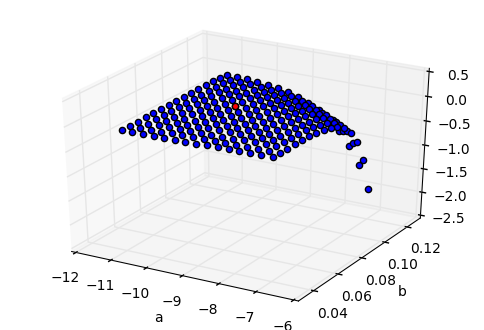

In [4]:
#Define the loglikelihood function
def ll_gompertz(y,X,a,b):
    rate = np.exp(a + b * X[:,0])    
    ll = (y * np.log(rate) - X[:,1] * rate)
    return ll

class Gompertz(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Gompertz, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        a = params[0]
        b = params[1]
        ll = ll_gompertz(self.endog, self.exog, a, b)
        return -ll
    def fit(self, start_params = None, maxiter = 100000,maxfun = 5000,**kwds):
        if start_params == None:
            start_params = np.repeat(0.01,2) 
        return super(Gompertz, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

# We can take a look at the likelihood function.
arange = np.linspace(-7,-11,15)
brange = np.linspace(0.04,0.12,15)

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

max_ll = -np.inf
for a in arange:
    for b in brange:
        ll = sum(ll_gompertz(dxMale,gompertz_data,a,b))
        if ll > max_ll:
            max_ll = ll
            max_a = a
            max_b = b
        ax.scatter(a,b,ll)
ll = sum(ll_gompertz(dxMale,gompertz_data,max_a,max_b))
ax.scatter(max_a,max_b,ll,c ='red')
        
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('ll')

print('max ll',max_ll,' max_a: ', max_a,' max_b:',max_b)
#The highest log=likelihood value is the red dot.

In [5]:
mod_gompertz = Gompertz(dxMale,gompertz_data)
#Fit Gompertz model
res_gomp = mod_gompertz.fit()
#Print summary
print(res_gomp.summary())
#Set the optimal parameter values
a = res_gomp.params[0]
b = res_gomp.params[1]

Optimization terminated successfully.
         Current function value: 4058.067527
         Iterations: 80
         Function evaluations: 152
                               Gompertz Results                               
Dep. Variable:                      y   Log-Likelihood:            -4.0581e+05
Model:                       Gompertz   AIC:                         8.116e+05
Method:            Maximum Likelihood   BIC:                         8.116e+05
Date:                Thu, 13 Oct 2016                                         
Time:                        22:02:32                                         
No. Observations:                 100                                         
Df Residuals:                      98                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------

Gompertz survival function:
$$ S(t)=e^{-\frac{( e^{\lambda} )\ (\ {e^{\gamma t} - 1})}{\gamma}} $$

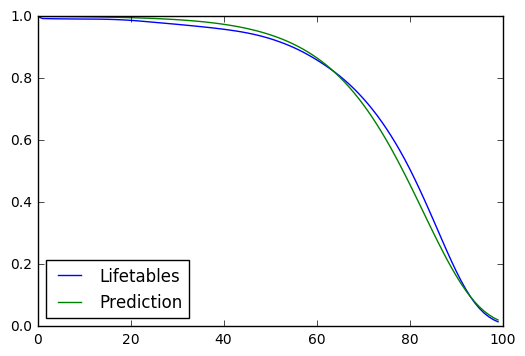

In [6]:
plt.figure(2)
plt.plot(age,survivalMale,label = 'Lifetables')
survivalPredict = np.exp(- np.exp(a) * (np.exp(b * time) - 1)/b)
plt.plot(age,survivalPredict,label = 'Prediction')
plt.legend(loc="lower left")